# 0. Configuración de entorno

In [2]:
%pip install pandas scikit-learn nltk matplotlib seaborn openpyxl python-dotenv -q
%pip install -q -U google-genai 
%pip install -U google-generativeai


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

from dotenv import load_dotenv
load_dotenv()

from google import genai
from google.genai import types
client = genai.Client()

import joblib
import utils
import json
import re

dict_ods = {
    1: "Fin de la pobreza",
    3: "Salud y bienestar",
    4: "Educación de calidad",
}

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juanf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\juanf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
df_original = pd.read_excel('../data/Datos_proyecto.xlsx')
df_original_clean = utils.clean_df(df_original)
df_new = pd.read_excel('../data/Datos_etapa 2.xlsx')
df_new_clean = utils.clean_df(df_new)


---

# 1. Procedimiento

Para llevar a cabo la fase de re-entrenamiento, se analizó el requerimiento del proyecto. El enunciado indica: "Una vez incorporados estos datos sintéticos junto con los news datos, al conjunto original, se debe reentrenar el modelo...".

Una interpretación literal de esta frase podría sugerir mezclar todos los conjuntos de datos (original, Datos_etapa_2 y los sintéticos) para el entrenamiento. Sin embargo, como equipo hemos identificado que este enfoque no se alinea con las buenas prácticas de la ciencia de datos, ya que introduciría un problema conocido como fuga de datos (data leakage).

La fuga de datos ocurriría porque el conjunto `Datos_etapa_2` está explícitamente destinado a evaluar el rendimiento del modelo. Si se incluye en el entrenamiento, estaríamos evaluando el modelo con datos que ya ha "visto", lo que invalidaría por completo el objetivo de los resultados y generaría métricas de rendimiento artificialmente altas y poco realistas.

para garantizar una evaluación rigurosa y metodológicamente correcta, se adoptó el siguiente procedimiento:
- **Fase 1: Establecimiento de la Línea Base (Benchmark)**
    - Cargar el mejor modelo de la etapa 1
    - Utilizar ese modelo para realizar predicciones sobre Datos_Etapa_2
    - Calcular y guardar métricas de rendimiento
- **Fase 2: Aumentación de Datos y Re-entrenamiento:**
    - Dividir el conjunto de datos originales en `train_original` y `test_original`
    - Identificar la clase minoritaria
    - Mediante técnicas de prompting generar datos sintéticos de alta calidad
    - Crear el conjunto `train_final` siendo el resulatado de `train_original` unido con los datos sinteticos generados
    - Re entrenar el modelo con los datos de `train_final`
    - Calcular y guardar métricas de rendimiento
- **Fase 3: Evaluación comparativa:**
    - Evaluar al modelo re-entrenado con el conjunto `Datos_etapa_2`
    - Comparar los resultados anteriores con los de la fase 1 para verificar si las metrica mejoraron con el prompting



---
# Fase 1: Establecimiento de linea base (Benchmark)
## 1.1 Cargar el mejor modelo de la etapa 1


In [5]:
best_model_etapa1 = joblib.load('../etapa1/best_model_etapa1.pkl')

## 1.2 Predecir los datos news

In [6]:
X_new = df_new_clean['textos']
y_new = df_new_clean['labels']
y_new_pred = best_model_etapa1.predict(X_new)

## 1.3 Calcular métricas


In [7]:

print("Accuracy:", accuracy_score(y_new, y_new_pred))
print("F1-macro:", f1_score(y_new, y_new_pred, average='macro'))
print("Precision:", precision_score(y_new, y_new_pred, average='macro'))
print("Recall:", recall_score(y_new, y_new_pred, average='macro'))
# print("\nMatriz de confusión:\n", confusion_matrix(y_new, y_new_pred))
# print("\nReporte de clasificación:\n", classification_report(y_new, y_new_pred))


Accuracy: 0.9292929292929293
F1-macro: 0.9227234753550544
Precision: 0.9430894308943089
Recall: 0.9132521225544482


Estos resultados muestran un claro overfiting en el modelo mostrando que este memoriza en su mayoria muy bien datos del mismo conjunto de train, pero que para datos nuevos suele fallar más.

---

# Fase 2: Aumentación de Datos y Re-entrenamiento
## 2.2 Dividir los datos del conjunto original en test y train


In [8]:
train_original, test_original = train_test_split(
    df_original_clean,
    test_size=0.30,
    random_state=42,
    stratify=df_original_clean["labels"]  # mantiene proporciones de clase
)


## 2.3 Identificar la clase minoritarias


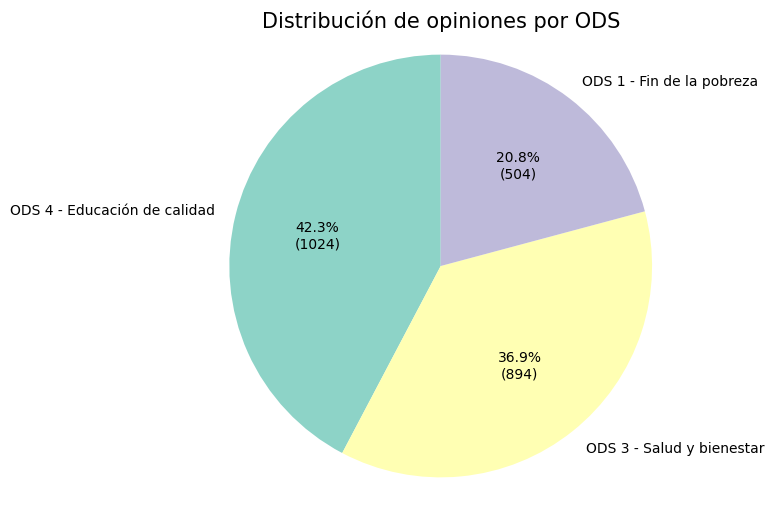

Clase minoritaria: 1


In [9]:

minoritaria = df_original_clean['labels'].value_counts().idxmin()

label_counts = df_original_clean['labels'].value_counts()
label_counts.index = label_counts.index.map(lambda i: f"ODS {i} - {dict_ods.get(i, 'Desconocido')}")

plt.figure(figsize=(6, 6))
plt.pie(
    label_counts,
    labels=label_counts.index,
    autopct=lambda p: f'{p:.1f}%\n({int(p * sum(label_counts) / 100)})',
    startangle=90,
    colors=plt.cm.Set3.colors
)

plt.title("Distribución de opiniones por ODS", fontsize=15)
plt.axis("equal")  # Mantiene el círculo perfecto
plt.show()

print(f"Clase minoritaria: {minoritaria}")


La clase minoritaria es el ODS 1 (Fin de la pobreza), mediante prompting se buscaria aumentar sus registros por lo menos hasta 900

## 2.4 Generar datos sintéticos con técnicas de prompting


In [30]:
semillas = (
    df_original[df_original['labels']==minoritaria]['textos']      # filtra solo filas de la clase minoritaria y se queda con la columna de texto
      .dropna()                          # quita textos vacíos/NaN
      .astype(str)                       # asegura que todo sea string
      .sample(                           # toma una muestra aleatoria
          min(8, sum(df_original['labels']==minoritaria)),  # hasta 8 textos, pero nunca más de los que hay
          random_state=42                      # para que la muestra sea reproducible
      )
      .tolist()                          # lo convierte a lista de strings
)
ejemplos = "\n".join(f"- {s}" for s in semillas)

prompt = f"""
Genera 200 opiniones ciudadanas breves (3-6 oraciones), en español de Colombia,
realistas y respetuosas, sobre problemáticas locales mapeadas SOLO al ODS {minoritaria}.
Definición de cada ODS: ODS 1: Fin de la pobreza, ODS 3: Salud y Bienestar, ODS 4: Educación de calidad
Requisitos:
- TODAS deben corresponder al ODS {minoritaria}.
- Varía zonas (urbano/rural), actores e instituciones; evita datos personales.
- Mantén neutralidad política y sin contenido sensible.
- TODAS deben tener más de 350 caracteres.
- Cada opinion debe ser diferente, no pueden haber opiniones duplicados.
- Entrega SOLO lista válida: una lista de string con las opiniones.

Ejemplos de nuestro dataset (NO copiar, solo inspirarse):
{ejemplos if 'ejemplos' in globals() and ejemplos else '- (sin ejemplos de contexto)'}

"""

print(prompt)


Genera 200 opiniones ciudadanas breves (3-6 oraciones), en español de Colombia,
realistas y respetuosas, sobre problemáticas locales mapeadas SOLO al ODS 1.
Definición de cada ODS: ODS 1: Fin de la pobreza, ODS 3: Salud y Bienestar, ODS 4: Educación de calidad
Requisitos:
- TODAS deben corresponder al ODS 1.
- Varía zonas (urbano/rural), actores e instituciones; evita datos personales.
- Mantén neutralidad política y sin contenido sensible.
- TODAS deben tener más de 350 caracteres.
- Cada opinion debe ser diferente, no pueden haber opiniones duplicados.
- Entrega SOLO lista válida: una lista de string con las opiniones.

Ejemplos de nuestro dataset (NO copiar, solo inspirarse):
- En tres (Chile, Perú y Uruguay), el efecto de este factor se vio potenciado por una mejora en la distribución, al menos en el área de distribución cercana a la línea de pobreza. Por otro lado, la tendencia a la baja de la pobreza en Argentina y República Dominicana fue, en parte, frenada —no ayudada— por cam

In [31]:
response2 = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=prompt,
    config=types.GenerateContentConfig(
        system_instruction="Eres un generador de datos sintéticos.",
        temperature=0.8,
        thinking_config=types.ThinkingConfig(thinking_budget=0)
    )
)

print(response2.text)

```json
[
  "En mi comunidad rural de Nariño, la falta de vías adecuadas es un obstáculo enorme para que los campesinos puedan sacar sus productos al mercado. Esto nos condena a precios bajos y nos impide mejorar nuestras condiciones de vida, perpetuando un ciclo de pobreza que parece no tener fin y afecta a todas las familias de la vereda. Es urgente una inversión en infraestructura vial que permita la comercialización justa de nuestros cultivos.",
  "La informalidad laboral en Cartagena es un problema grave que afecta a miles de familias. Muchos jóvenes no tienen acceso a contratos dignos, seguridad social ni prestaciones. Viven al día, con la incertidumbre de no saber si mañana tendrán para comer, lo que dificulta cualquier tipo de planificación a largo plazo y la posibilidad de salir de la pobreza. Necesitamos programas que promuevan la formalización y el emprendimiento.",
  "En el barrio El Poblado de Medellín, a pesar de la aparente prosperidad, hay muchas personas mayores que vi

In [32]:
display(response2.usage_metadata)

GenerateContentResponseUsageMetadata(
  candidates_token_count=35842,
  prompt_token_count=1215,
  prompt_tokens_details=[
    ModalityTokenCount(
      modality=<MediaModality.TEXT: 'TEXT'>,
      token_count=1215
    ),
  ],
  total_token_count=37057
)

In [33]:
response2.text

'```json\n[\n  "En mi comunidad rural de Nariño, la falta de vías adecuadas es un obstáculo enorme para que los campesinos puedan sacar sus productos al mercado. Esto nos condena a precios bajos y nos impide mejorar nuestras condiciones de vida, perpetuando un ciclo de pobreza que parece no tener fin y afecta a todas las familias de la vereda. Es urgente una inversión en infraestructura vial que permita la comercialización justa de nuestros cultivos.",\n  "La informalidad laboral en Cartagena es un problema grave que afecta a miles de familias. Muchos jóvenes no tienen acceso a contratos dignos, seguridad social ni prestaciones. Viven al día, con la incertidumbre de no saber si mañana tendrán para comer, lo que dificulta cualquier tipo de planificación a largo plazo y la posibilidad de salir de la pobreza. Necesitamos programas que promuevan la formalización y el emprendimiento.",\n  "En el barrio El Poblado de Medellín, a pesar de la aparente prosperidad, hay muchas personas mayores q

In [34]:
clean_s = re.sub(r"^```json\s*|\s*```$", "", response2.text.strip())
lista1 = json.loads(clean_s)
lista1

['En mi comunidad rural de Nariño, la falta de vías adecuadas es un obstáculo enorme para que los campesinos puedan sacar sus productos al mercado. Esto nos condena a precios bajos y nos impide mejorar nuestras condiciones de vida, perpetuando un ciclo de pobreza que parece no tener fin y afecta a todas las familias de la vereda. Es urgente una inversión en infraestructura vial que permita la comercialización justa de nuestros cultivos.',
 'La informalidad laboral en Cartagena es un problema grave que afecta a miles de familias. Muchos jóvenes no tienen acceso a contratos dignos, seguridad social ni prestaciones. Viven al día, con la incertidumbre de no saber si mañana tendrán para comer, lo que dificulta cualquier tipo de planificación a largo plazo y la posibilidad de salir de la pobreza. Necesitamos programas que promuevan la formalización y el emprendimiento.',
 'En el barrio El Poblado de Medellín, a pesar de la aparente prosperidad, hay muchas personas mayores que viven con pensi

In [35]:
df_generated1 = pd.DataFrame({
    "textos": lista1,
    "labels": 1  # valor fijo para toda la columna
})

df_generated1

,textos,labels
0,"En mi comunidad rural de Nariño, la falta de v...",1
1,La informalidad laboral en Cartagena es un pro...,1
2,"En el barrio El Poblado de Medellín, a pesar d...",1
3,La escasez de oportunidades educativas de cali...,1
4,"En la Guajira, la falta de acceso a servicios ...",1
...,...,...
451,La falta de acceso a la salud mental en poblac...,1
452,"En el Cesar, la falta de inversión en proyecto...",1
453,La falta de una política de vivienda digna y a...,1
454,"En Nariño, la dependencia económica de los cul...",1


In [36]:
# Generamos otros 200 para completar los 400
response3 = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=prompt,
    config=types.GenerateContentConfig(
        system_instruction="Eres un generador de datos sintéticos.",
        temperature=0.8,
        thinking_config=types.ThinkingConfig(thinking_budget=0)
    )
)

print(response3.text)

```json
[
  "En mi vereda, la falta de vías terciarias en buen estado dificulta enormemente el transporte de nuestros productos agrícolas al mercado, lo que se traduce en menores ingresos para las familias campesinas. Es crucial que el gobierno local invierta en infraestructura para mejorar nuestra calidad de vida y romper el ciclo de la pobreza rural que afecta a tantas comunidades. Esta situación nos impide acceder a precios justos y mantener una economía sostenible en la región, creando una barrera significativa para el desarrollo local y el bienestar general de todos los habitantes.",
  "Observo con preocupación cómo la informalidad laboral sigue siendo una constante en mi ciudad. Muchas personas trabajan sin contratos, sin seguridad social y con salarios precarios, lo que las deja en una situación de vulnerabilidad extrema ante cualquier eventualidad. Las autoridades deberían promover políticas que incentiven la formalización del empleo y garanticen condiciones dignas para todos l

In [37]:
display(response3.usage_metadata)

GenerateContentResponseUsageMetadata(
  candidates_token_count=20591,
  prompt_token_count=1215,
  prompt_tokens_details=[
    ModalityTokenCount(
      modality=<MediaModality.TEXT: 'TEXT'>,
      token_count=1215
    ),
  ],
  total_token_count=21806
)

In [38]:
clean_s = re.sub(r"^```json\s*|\s*```$", "", response3.text.strip())
lista2 = json.loads(clean_s)
lista2

['En mi vereda, la falta de vías terciarias en buen estado dificulta enormemente el transporte de nuestros productos agrícolas al mercado, lo que se traduce en menores ingresos para las familias campesinas. Es crucial que el gobierno local invierta en infraestructura para mejorar nuestra calidad de vida y romper el ciclo de la pobreza rural que afecta a tantas comunidades. Esta situación nos impide acceder a precios justos y mantener una economía sostenible en la región, creando una barrera significativa para el desarrollo local y el bienestar general de todos los habitantes.',
 'Observo con preocupación cómo la informalidad laboral sigue siendo una constante en mi ciudad. Muchas personas trabajan sin contratos, sin seguridad social y con salarios precarios, lo que las deja en una situación de vulnerabilidad extrema ante cualquier eventualidad. Las autoridades deberían promover políticas que incentiven la formalización del empleo y garanticen condiciones dignas para todos los trabajado

In [39]:
df_generated2 = pd.DataFrame({
    "textos": lista2,
    "labels": 1  # valor fijo para toda la columna
})
df_generated2

,textos,labels
0,"En mi vereda, la falta de vías terciarias en b...",1
1,Observo con preocupación cómo la informalidad ...,1
2,"En mi barrio, el acceso a servicios básicos co...",1
3,La falta de oportunidades de empleo para los j...,1
4,Las madres cabeza de hogar en mi municipio enf...,1
...,...,...
196,"En mi región, la falta de acceso a servicios d...",1
197,La falta de programas de formación y capacitac...,1
198,"En mi comunidad, la falta de programas de aten...",1
199,La falta de acceso a servicios de salud sexual...,1


In [40]:
df_generated = pd.concat([df_generated1, df_generated2], ignore_index=True)
df_generated

,textos,labels
0,"En mi comunidad rural de Nariño, la falta de v...",1
1,La informalidad laboral en Cartagena es un pro...,1
2,"En el barrio El Poblado de Medellín, a pesar d...",1
3,La escasez de oportunidades educativas de cali...,1
4,"En la Guajira, la falta de acceso a servicios ...",1
...,...,...
652,"En mi región, la falta de acceso a servicios d...",1
653,La falta de programas de formación y capacitac...,1
654,"En mi comunidad, la falta de programas de aten...",1
655,La falta de acceso a servicios de salud sexual...,1


In [41]:
df_generated_clean = utils.clean_df(df_generated)

Hay 369 duplicados
Duplicados eliminados


In [42]:
# Generamos otros 200
response4 = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=prompt,
    config=types.GenerateContentConfig(
        system_instruction="Eres un generador de datos sintéticos.",
        temperature=0.8,
        thinking_config=types.ThinkingConfig(thinking_budget=0)
    )
)

print(response4.text)

```json
[
  "Es crucial que las entidades gubernamentales en zonas rurales del Chocó implementen programas de apoyo para pequeños agricultores, facilitando el acceso a créditos y capacitaciones. Muchos campesinos luchan diariamente para asegurar el sustento de sus familias, y la falta de oportunidades los mantiene en un ciclo de pobreza. Necesitamos políticas que fortalezcan la economía local y brinden estabilidad, permitiendo a estas comunidades prosperar sin tener que desplazarse a las ciudades, donde a menudo enfrentan nuevas adversidades.",
  "La situación de los adultos mayores en Barranquilla es preocupante. Aquellos que no tuvieron acceso a pensión viven en condiciones de extrema vulnerabilidad. Es indispensable que se amplíen los programas de subsidios y asistencia social, garantizando una vejez digna para quienes dedicaron su vida a construir este país. La falta de apoyo institucional genera una carga enorme para las familias, que muchas veces también enfrentan sus propias dif

In [43]:
display(response4.usage_metadata)

GenerateContentResponseUsageMetadata(
  candidates_token_count=31483,
  prompt_token_count=1215,
  prompt_tokens_details=[
    ModalityTokenCount(
      modality=<MediaModality.TEXT: 'TEXT'>,
      token_count=1215
    ),
  ],
  total_token_count=32698
)

In [44]:
clean_s = re.sub(r"^```json\s*|\s*```$", "", response4.text.strip())
lista3 = json.loads(clean_s)
lista3

['Es crucial que las entidades gubernamentales en zonas rurales del Chocó implementen programas de apoyo para pequeños agricultores, facilitando el acceso a créditos y capacitaciones. Muchos campesinos luchan diariamente para asegurar el sustento de sus familias, y la falta de oportunidades los mantiene en un ciclo de pobreza. Necesitamos políticas que fortalezcan la economía local y brinden estabilidad, permitiendo a estas comunidades prosperar sin tener que desplazarse a las ciudades, donde a menudo enfrentan nuevas adversidades.',
 'La situación de los adultos mayores en Barranquilla es preocupante. Aquellos que no tuvieron acceso a pensión viven en condiciones de extrema vulnerabilidad. Es indispensable que se amplíen los programas de subsidios y asistencia social, garantizando una vejez digna para quienes dedicaron su vida a construir este país. La falta de apoyo institucional genera una carga enorme para las familias, que muchas veces también enfrentan sus propias dificultades ec

In [45]:
df_generated3 = pd.DataFrame({
    "textos": lista3,
    "labels": 1  # valor fijo para toda la columna
})
df_generated3

,textos,labels
0,Es crucial que las entidades gubernamentales e...,1
1,La situación de los adultos mayores en Barranq...,1
2,"En las comunas de Medellín, la falta de oportu...",1
3,La informalidad laboral en Cali es un problema...,1
4,En las comunidades indígenas de la Sierra Neva...,1
...,...,...
333,La falta de inversión en infraestructura turís...,1
334,"En las zonas rurales del Amazonas, la falta de...",1
335,La dificultad para acceder a la justicia en zo...,1
336,"En los barrios populares de Leticia, la falta ...",1


In [46]:
df_generated = pd.concat([df_generated1, df_generated2, df_generated3], ignore_index=True)
df_generated

,textos,labels
0,"En mi comunidad rural de Nariño, la falta de v...",1
1,La informalidad laboral en Cartagena es un pro...,1
2,"En el barrio El Poblado de Medellín, a pesar d...",1
3,La escasez de oportunidades educativas de cali...,1
4,"En la Guajira, la falta de acceso a servicios ...",1
...,...,...
990,La falta de inversión en infraestructura turís...,1
991,"En las zonas rurales del Amazonas, la falta de...",1
992,La dificultad para acceder a la justicia en zo...,1
993,"En los barrios populares de Leticia, la falta ...",1


In [47]:
df_generated_clean = utils.clean_df(df_generated)

Hay 500 duplicados
Duplicados eliminados


In [48]:
df_generated_clean

,textos,labels
0,comun rural nariñ falt vias adecu obstacul eno...,1
1,informal laboral cartagen problem grav afect m...,1
2,barri pobl medellin pe aparent prosper much pe...,1
3,escasez oportun educ calid zon perifer cali pr...,1
4,guajir falt acces servici basic agu potabl san...,1
...,...,...
864,falt acces servici salud mental zon apart colo...,1
879,zon rural sucr falt acces servici bancari fina...,1
880,dificult acced justici zon apart sucr dej much...,1
882,dificult acced merc product agricol boliv deb ...,1


In [49]:
# Se eliminan al azar para cumplir con añadir cerca de 400 registros nuevos
df_generated_clean = df_generated_clean.sample(400, random_state=42)
df_generated_clean


,textos,labels
828,zon rural amazon falt acces servici bancari fi...,1
73,falt acces aliment adecu much comun rural huil...,1
679,falt program reincorpor efect excombatient sur...,1
176,ce falt inversion proyect product sosten zon r...,1
702,barri perifer florenci falt alumbr public segu...,1
...,...,...
210,barrancabermej falt oportun laboral joven acce...,1
216,san andres dependent turism gener econom fragi...,1
664,barri perifer bogot alto cost viviend empuj mu...,1
824,zon rural vaupes falt acces energ electr limit...,1


## 2.4 Unir los datos originales de test con los sintéticos


In [50]:
df_total = pd.concat([train_original,df_generated_clean], ignore_index=True)
df_total

,textos,labels
0,podr involucr sistem acredit certific escuel c...,4
1,marc ahor establec enfoqu nacional acord integ...,4
2,hogar inform val cuatr ole pued riesg entrar s...,1
3,esfuerz profesional segu form modern educ medi...,3
4,ejempl umbral pobrez defin ingres medi pais mi...,1
...,...,...
2091,barrancabermej falt oportun laboral joven acce...,1
2092,san andres dependent turism gener econom fragi...,1
2093,barri perifer bogot alto cost viviend empuj mu...,1
2094,zon rural vaupes falt acces energ electr limit...,1


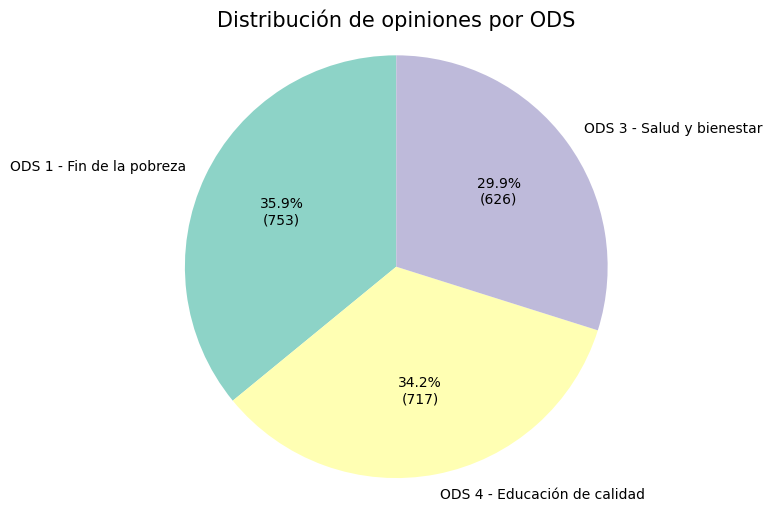

In [51]:

label_counts = df_total['labels'].value_counts()
label_counts.index = label_counts.index.map(lambda i: f"ODS {i} - {dict_ods.get(i, 'Desconocido')}")

plt.figure(figsize=(6, 6))
plt.pie(
    label_counts,
    labels=label_counts.index,
    autopct=lambda p: f'{p:.1f}%\n({int(p * sum(label_counts) / 100)})',
    startangle=90,
    colors=plt.cm.Set3.colors
)

plt.title("Distribución de opiniones por ODS", fontsize=15)
plt.axis("equal")  # Mantiene el círculo perfecto
plt.show()


## 2.5 Re entrenar el modelo


In [55]:
X_train = df_total['textos']
y_train = df_total['labels']

X_test = test_original['textos']
y_test = test_original['labels']

model = Pipeline([
    ('vect', TfidfVectorizer(
        # max_features=5000,       # puedes ajustar el número de palabras
        # ngram_range=(1,2),       # usa unigramas y bigramas
        # stop_words='spanish'     # elimina palabras comunes en español
    )),
    ('clf', LinearSVC(random_state=42, C=1, class_weight='balanced'))
])

new_model = model.fit(X_train , y_train)

y_pred = model.predict(X_test)

## 2.6 Calcular métricas


In [56]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.9711538461538461
Precision: 0.9711598055737868
Recall: 0.9711538461538461
F1-score: 0.971136006356323


---

# Fase 3: Evaluación comparativa:
## 3.1 Calcular metricas del modelo re entrenado con los datos news


In [57]:
X_new = df_new_clean['textos']
y_new = df_new_clean['labels']

y_new_pred = new_model.predict(X_new)

print("Accuracy:", accuracy_score(y_new, y_new_pred))
print("F1-macro:", f1_score(y_new, y_new_pred, average='macro'))
print("Precision:", precision_score(y_new, y_new_pred, average='macro'))
print("Recall:", recall_score(y_new, y_new_pred, average='macro'))

Accuracy: 0.9494949494949495
F1-macro: 0.9453265316966896
Precision: 0.9483697983697984
Recall: 0.9432262827611665


## 3.2 Compar resultados


**Tabla 1: Comparativa de Rendimiento en el Conjunto de train**


| Métrica | Modelo Original | Modelo Re-entrenado (con Aumentación) |
| :--- | :---: | :---: |
| F1-Score (Macro) | **1.000** | 0.9711 |
| Accuracy |  | 0.9712 |
| Precision (Macro) |  | 0.9712 |
| Recall (Macro) |  | 0.9711 |


**Tabla 2: Comparativa de Rendimiento en el Conjunto de PRUEBA (`Datos_etapa_2`)**

Esta tabla muestra el rendimiento de cada modelo sobre el conjunto de prueba, que contiene datos nuevos y nunca antes vistos.

| Métrica | Modelo Original | Modelo Re-entrenado (con Aumentación) |
| :--- | :---: | :---: |
| F1-Score (Macro) | 0.9233 | 0.9453 |
| Accuracy | 0.9293 | 0.9494 |
| Precision (Macro) | 0.9431 | 0.9484 |
| Recall (Macro) | 0.9132 | 0.9432 |



### **Conclusión de Resultados**

Los resultados obtenidos demuestran de manera contundente el éxito de la estrategia de aumentación de datos mediante *prompting*.

Se pueden extraer dos conclusiones principales:

1.  **Se corrigió el Sobreajuste (Overfitting):** La **Tabla 1** revela que el modelo original estaba severamente sobreajustado, evidenciado por un F1-Score perfecto de **1.0** en los datos de entrenamiento. El modelo re-entrenado presenta un F1-Score más realista de **0.971**, lo que indica que ha dejado de "memorizar" los datos para aprender a generalizar patrones, creando un modelo mucho más robusto.

2.  **Mejora Demostrable en el Rendimiento Real:** La prueba definitiva del éxito se encuentra en la **Tabla 2**. El modelo re-entrenado supera al original en todas las métricas de evaluación sobre datos nuevos. El **aumento del F1-Score de 0.923 a 0.945** es particularmente significativo, ya que demuestra que la mayor capacidad de generalización se traduce directamente en una mayor precisión para clasificar opiniones del mundo real.

En resumen, el procedimiento no solo solucionó un problema metodológico crítico como el sobreajuste, sino que también entregó un modelo final con un rendimiento tangiblemente superior.

In [58]:
# Exportar modelo
joblib.dump(model, "first_model.pkl")

['first_model.pkl']